In [2]:
library(devtools)
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/metacell_functions.r")
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/pic_parser.r")
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(metacell)
library(ggplot2)
library(ggrepel)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(grid)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(shades)
library(circlize)
library(tglkmeans)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(cowplot)
library(R.utils)
library(rstatix) 
library(RVAideMemoire)
library(cluster)   
library(factoextra) 
library(ggpmisc)

Loading required package: usethis

ℹ SHA-1 hash of file is "bda7f06ee7b168c0be4c723ee15644ab99e6421e"
Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: reshape2

Loading required package: RANN

Loading required package: plyr

Loading required package: plotrix

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:plotrix’:

    plotCI


The following object is masked from ‘package:stats’:

    lowess


Loading required package: parallel

Loading required package: compositions

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


Loading required package: RCurl

ℹ SHA-1 hash of file is "9adfcccbce

Loading required package: vioplot

Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) for summary information

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘shades’


The following object is masked from ‘package:SummarizedExperiment’:

    distance


The following object is masked from ‘package:GenomicRanges’:

    distance


The following objects are masked from ‘package:IRanges’:

    distance, space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:gplots’:

    space


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R

simulate_doublets = function(mat_id, a_cells, b_cells, k, comb=NA, numis = 1000, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    umis = umis[sim_genes,]
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    cell_sizes = colSums(umis)
    a_modifier = pmax(ceiling(numis_a / cell_sizes[sim_cells_a]), 1)
    b_modifier = pmax(ceiling(numis_b / cell_sizes[sim_cells_b]), 1)
    a_umis = .downsamp_var(sweep(umis[,sim_cells_a], 2, a_modifier, "*"), numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = .downsamp_var(sweep(umis[,sim_cells_b], 2, b_modifier, "*"), numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [3]:
estimate_mixing = function(sim_umis, alpha, genes, fname, numis, normalize = T) {
	
	sim_n = sweep(sim_umis, 2, colSums(sim_umis), "/") * numis
	if (normalize) { us = sim_n} else {us = sim_umis}
	alpha_fit = cv.glmnet(t(us[genes,]), alpha)
	alpha_tag = predict(alpha_fit, newx = t(us[genes,]), s = "lambda.min")
	i = which(alpha_fit$lambda == alpha_fit$lambda.min)
	if (!is.null(fname)) {
		png(fname, height=1000, width=1000)
		#par(bg = bg, fg = fg, col.axis = col.axis, col.lab = col.lab)
	}
	lim = c(0,1)
	plot(alpha_tag, alpha, pch = 20, , col = "gray", axes = F, xlab = "", ylab = "", cex = 2, xlim = lim, ylim = lim,
		main = round(1 - alpha_fit$cvm[i] / var(alpha),4))
	axis(1); axis(2); abline(coef = c(0,1), lwd = 2)
        if (!is.null(fname)) {dev.off()}
	alpha_fit
}


run_pic_seq = function(mc_id, mat_id, pic_umis, a_cells, b_cells, 
	lr_features, mle_features, fname, numis = 1000, 
	lr_k = 2e4, bad_genes = c(), comb = NULL, reg = 1e-4, downsample=T) {
	
	sc_cl = scdb_mc(mc_id); sc_mat = scdb_mc(mat_id); 
	cells = union(a_cells, b_cells)
	lr_features = setdiff(lr_features, bad_genes)
	mle_features = setdiff(mle_features, bad_genes)
	if (is.null(comb)) {comb = rep("X", length(cells)); names(comb) = cells}

	message("Simulating ", lr_k, " PIC (numis = ", numis, ") for alpha estimation")
	lr_res = simulate_doublets(mat_id, a_cells, b_cells, lr_k, comb, numis = rep(numis, lr_k))
	sim_umis = lr_res$sim_umis; sim_info = lr_res$info
	sim_cells = names(which(colSums(sim_umis) == numis))
	sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]

        message("Building LR for alpha")
	alpha_fit = estimate_mixing(sim_umis, sim_info$alpha.1, lr_features, fname, numis)

	message("Running MLE on PIC")
	
	if (downsample) {
		ds = .downsamp(pic_umis, numis)
	} else {
		ds = pic_umis
	}
	real_t_frac = predict(alpha_fit, newx = t(ds[lr_features,]), s = "lambda.min")
	alpha = real_t_frac[colnames(ds),]
	good_cells = intersect(colnames(ds), names(which(alpha >= 0 & alpha <= 1)))
	mle_res = assign_pics_to_singlets(mc_id, mat_id, ds[,good_cells], a_cells, b_cells, alpha[good_cells],
		verbose=T, bad_genes = bad_genes, markers = mle_features, reg = reg)

	t_mc = mle_res$a_mc; dc_mc = mle_res$b_mc
	names(t_mc) = rownames(mle_res); names(dc_mc) = rownames(mle_res)
	mle_res$alpha = alpha[good_cells]

        mle_res
}


In [4]:
pic_ll_to_pair = function(mc_id, mat_id, pic_umis, mc_a, mc_b, alpha, bins = length(alpha), reg = 1e-6, markers = NULL) {

        sc_cl = scdb_mc(mc_id); sc_mat = scdb_mat(mat_id)
        umis = read_large_umis(mat_id, cells = names(sc_cl@mc))
	if (is.null(markers)) {
                mc_prof = sc_cl@e_gc[setdiff(rownames(sc_cl@e_gc), bad_genes),]
	} else {
                mc_prof = mc_compute_unnorm_fp(sc_cl@mc, umis[setdiff(markers, bad_genes),])
        }
	mc_prof = sweep(mc_prof, 2, colSums(mc_prof), "/")
        p_a = mc_prof[, mc_a] + reg
        p_b = mc_prof[, mc_b] + reg
        p = sweep(p_a, 2, alpha, "*") + sweep(p_b, 2, 1 - alpha, "*")
        u = pic_umis[rownames(mc_prof), ]
        ll = colSums(u * log(p)) + apply(u, 2, stirlings_lmulti)
	ll
}

In [5]:
# Rerun
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
if(!dir.exists("cd45_pic_figs")) dir.create("cd45_pic_figs/")
scfigs_init("cd45_pic_figs/")
if(!dir.exists("annotations")) dir.create("annotations/")

initializing scdb to scdb/



# PIC-seq preprocessing

In [6]:
bad_genes = read_lines('annotations/kinetics_filtered_genes.txt')

In [7]:
# Rerun

message("Loading singlets dataset:")
sc_mat = scdb_mat("kinetics_singlets")
message("Loaded a UMI matrix of ", sc_mat@ncells, " cells and ", sc_mat@ngenes, " genes.")
sin_2d = scdb_mc2d("kinetics_2dproj")
sin_cl = scdb_mc("kinetics_mc"); sin_mat = scdb_mat("kinetics_singlets")
lfp = log2(sin_cl@mc_fp)
message("Loaded a metacell object of ", length(sin_cl@mc), " singlets. Total of ", length(table(sin_cl@mc)), " metacells.")

message("Loading PIC dataset:")
db_mat = scdb_mat("epcam_cd45_pics")
message("Loaded ", db_mat@ncells, " PICs")


Loading singlets dataset:

Loaded a UMI matrix of 41143 cells and 36892 genes.

Loaded a metacell object of 39782 singlets. Total of 715 metacells.

Loading PIC dataset:

Loaded 11009 PICs



In [8]:
alive_pics = db_mat@cells[db_mat@cell_metadata$pct_counts_mt < 30]

In [9]:
ticks = c(100, 300, 500, 750, 1000, 2000, 10000)

Saving 6.67 x 6.67 in image


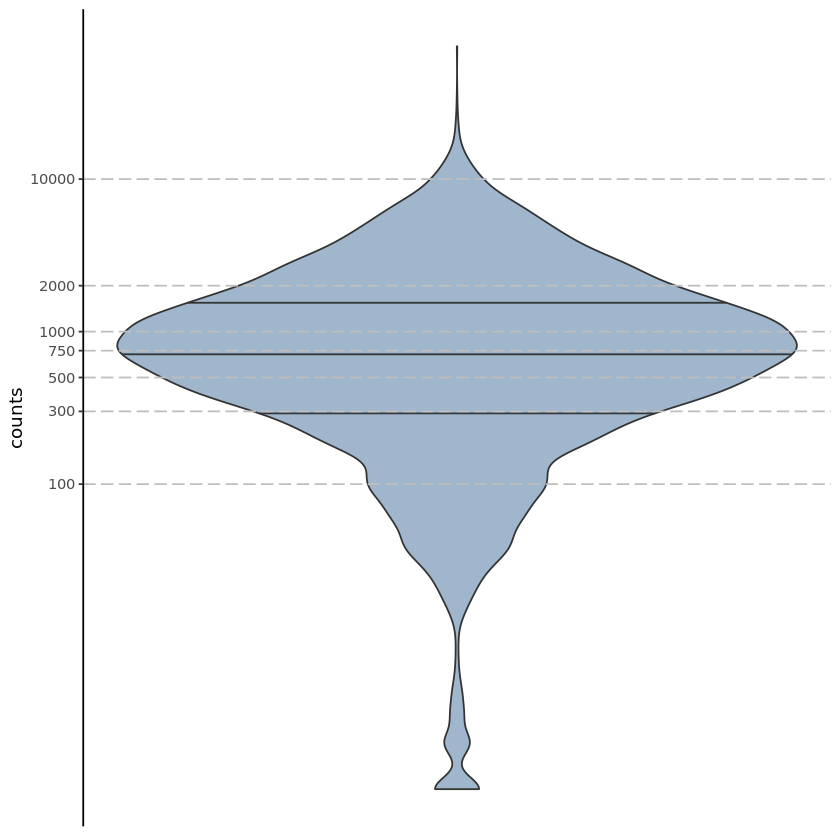

In [10]:
# Supp a

data.frame(counts=db_mat@cell_metadata[#db_mat@cell_metadata$total_counts >= 10 &
                                       rownames(db_mat@cell_metadata) %in% alive_pics, 'total_counts']) %>%
    ggplot(aes(x=1, y=counts)) +
    geom_violin(fill='slategray3', draw_quantiles = c(0.25, 0.5, 0.75)) +
    #geom_jitter(alpha=0.2, color='slategray') +
    scale_y_log10(breaks=ticks) +
    geom_hline(yintercept = ticks, linetype='longdash', color='gray') +
    #geom_label(data = data.frame(n=ticks), aes(y=n, label=n)) +
    theme(axis.title.x = element_blank(), axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x=element_blank(),
          )

ggsave("final_figs/supp3/umi_counts.png", dpi=1200)

In [11]:
#rerun
sin_cl@color_key <- data.frame(group=unique(sin_cl@annots), color=unique(sin_cl@colors))

In [12]:
#rerun
color_scheme = sin_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group
sin_names = color2name[ sin_cl@colors[ sin_cl@mc]]; names(sin_names) = names(sin_cl@mc)

In [13]:
#rerun
lymphoid_order = c(32, 33, 34, 35, 26, 28, 27, 25, 24, 36, 31)
myeloid_order = c(39, 40, 37, 42, 44, 41, 43, 29, 23, 30, 38)
epithelial_order = c(13, 17, 14, 18, 22, 19, 21, 12, 16, 15)
stromal_order = c(1, 3, 10, 11, 9)
fibroblast_order = c(6, 4, 5, 7, 8)

order_index = c(lymphoid_order, myeloid_order, epithelial_order, stromal_order, fibroblast_order)
cell_order = unique(sin_cl@annots)[order_index]

In [14]:
cell_order

[1] "T cells"              "CD8 T cells"          "Treg"                
 [4] "gd T cells"           "gd NKT Ccl5 l"        "gd NKT Ccl5 h"       
 [7] "NKT cells"            "NK cells"             "Cytotoxic NK"        
[10] "ILC2"                 "B cells"              "Monocytes"           
[13] "MonMacs"              "Perivasc macs"        "Ductal macs"         
[16] "cDC1"                 "cDC2"                 "pDC"                 
[19] "Mreg DCs"             "Mast cells"           "Basophils"           
[22] "Neutrophils"          "Progenitor 1"         "Progenitor 2"        
[25] "Alveolar"             "HS"                   "Myoepithelial"       
[28] "Basal"                "MyoLum"               "Alveolar spp l"      
[31] "Alveolar spp1 h"      "Alveolar secretory"   "Endothelial"         
[34] "Mcam Endothelial"     "Smooth muscle"        "Pericytes"           
[37] "Schwann cells"        "fibroblasts"          "Dpp4 fibroblasts"    
[40] "IFN Dpp4 fibroblasts" "CAFs"                 "Pre-adipocytes"

In [15]:
unique(sin_cl@annots)[!unique(sin_cl@annots) %in% cell_order]

[1] "doublets"  "Hair-like"

In [16]:
cond_order = c("tumor", "normal")

In [17]:
age_order = c("10d", "3w", "6w", "8w", "10w", "12w")

In [18]:
group.colors = unique(sin_cl@colors)[order_index]
names(group.colors) = cell_order

In [19]:
sin_stats = sc_mat@cell_metadata[names(sin_cl@mc),]

In [20]:
cat(cell_order, sep = '", "')

T cells", "CD8 T cells", "Treg", "gd T cells", "gd NKT Ccl5 l", "gd NKT Ccl5 h", "NKT cells", "NK cells", "Cytotoxic NK", "ILC2", "B cells", "Monocytes", "MonMacs", "Perivasc macs", "Ductal macs", "cDC1", "cDC2", "pDC", "Mreg DCs", "Mast cells", "Basophils", "Neutrophils", "Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Alveolar spp l", "Alveolar spp1 h", "Alveolar secretory", "Endothelial", "Mcam Endothelial", "Smooth muscle", "Pericytes", "Schwann cells", "fibroblasts", "Dpp4 fibroblasts", "IFN Dpp4 fibroblasts", "CAFs", "Pre-adipocytes

In [21]:
#rerun
epithelial_pops = c("Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Alveolar spp l", 
                    "Alveolar spp1 h", "Alveolar secretory")
immune_pops = c("T cells", "CD8 T cells", "Treg", "gd T cells", "gd NKT Ccl5 l", "gd NKT Ccl5 h", "NKT cells", "NK cells", 
                "Cytotoxic NK", "ILC2", "B cells", "Monocytes", "MonMacs", "Perivasc macs", "Ductal macs", "cDC1", "cDC2", 
                "pDC", "Mast cells", "Mreg DCs", "Basophils", "Neutrophils")

epithelial_mc = which(color2name[ sin_cl@colors] %in% epithelial_pops)
immune_mc = which(color2name[ sin_cl@colors] %in% immune_pops)
bad_mc = setdiff(names(table(sin_cl@mc)), union(epithelial_mc, immune_mc))

epithelial_cells = names(sin_names)[ sin_names %in% epithelial_pops]
immune_cells = names(sin_names)[ sin_names %in% immune_pops]

message(length(immune_cells), " immune cells and ", length(epithelial_cells), " epithelial cells")

16746 immune cells and 11757 epithelial cells



In [22]:
#rerun
epi_mat = sin_mat@mat[,epithelial_cells]
imm_mat = sin_mat@mat[,immune_cells]

In [23]:
markers = names(scdb_gset('kinetics_markers')@gene_set) # Set of features used for the Metacell clustering
bad_genes = union(grep("Gm[0-9].|Mir|-ps|Rpl|Rps|Jchain|Ftl1|Hsp|Rn18s-rs5|Actb|Tuba|Rik", sin_mat@genes, v=T),
                  read_lines('annotations/kinetics_filtered_genes.txt'))
markers = markers[!markers %in% bad_genes]

In [24]:
# Rerun
lr_features = read.table("annotations/cd45_lr_features.txt", h=F, stringsAsFactors = F)[[1]]
mle_features = read.table("annotations/cd45_mle_features.txt", h=F, stringsAsFactors = F)[[1]]

message("Chose ", length(lr_features), " features")
message("Chose ", length(mle_features), " features")

Chose 1003 features

Chose 747 features



In [195]:
imm_mat

   [[ suppressing 32 column names ‘AB529_E21’, ‘AB529_L9’, ‘AB529_B12’ ... ]]

   [[ suppressing 32 column names ‘AB529_E21’, ‘AB529_L9’, ‘AB529_B12’ ... ]]

   [[ suppressing 32 column names ‘AB529_E21’, ‘AB529_L9’, ‘AB529_B12’ ... ]]



36892 x 16746 sparse Matrix of class "dgCMatrix"
                                                                                     
0610005C13Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610006L08Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610009B22Rik  2 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610009E02Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610009L18Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610010K14Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610012D04Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610012G03Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610025J13Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
0610030E20Rik  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
06100

# Simulated PICs - for size threshold

In [24]:
k = 10000
numis = sample(100:1000, k, replace=T)

res = simulate_doublets(mat_id = "kinetics_singlets", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = numis)

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


,sim.1,sim.2,alpha.1,alpha.2
,<chr>,<chr>,<dbl>,<dbl>
Sim1,AB132_B24,AB250_C16,0.8612440,0.13875598
Sim2,AB149_E24,AB376_D18,0.9113924,0.08860759
Sim3,AB149_M9,AB286_I21,0.8912281,0.10877193
Sim4,AB167_M8,AB009_L17,0.4870775,0.51292247
Sim5,AB135_G3,AB134_N24,0.6489796,0.35102041
Sim6,AB117_I8,AB271_J12,0.6657929,0.33420708


In [25]:
scdb_add_mat("cd45_simpic_sizevar", sim_umis)

In [26]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "kinetics_mc", 
                                      mat_id = "kinetics_singlets", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [27]:
sim_mle_res$alpha = sim_alpha

In [28]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [29]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [30]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [31]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [32]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_sim_info_varsizes.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_sim_mle_res_varsizes.txt")

In [33]:
#Rerun
sim_info = read.delim("annotations/cd45_sim_info_varsizes.txt", row.names = 1)
sim_mle_res = read.delim("annotations/cd45_sim_mle_res_varsizes.txt", row.names = 1)

100

150

200

250

300

350

400

450

500

550

600

650

700

750

800

850

900

950

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


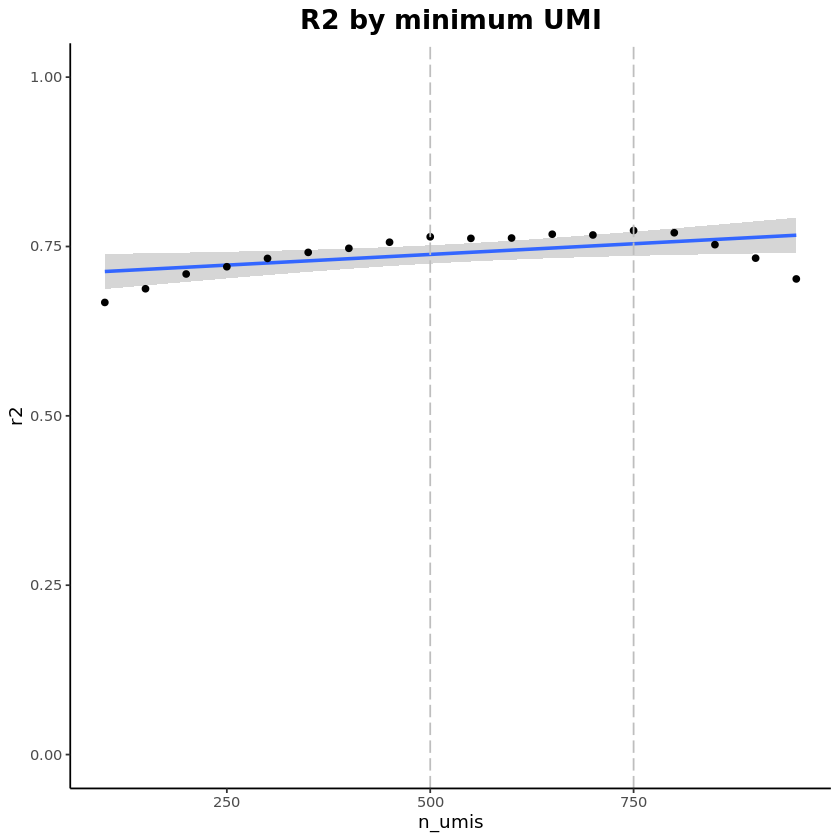

In [34]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), r2=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    message(x)
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    alpha_fit = estimate_mixing(sim_umis = sim_umis[,rel_cells], 
                                alpha = sim_info[rel_cells,'alpha.1'], 
                                genes = lr_features, 
                                fname = "./temp.png",
                                sim_sizes[rel_cells],
                                normalize = T)
    alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]
    i = which(alpha_fit$lambda == alpha_fit$lambda.min)
    r2 = round(1 - alpha_fit$cvm[i] / var(sim_info[rel_cells,'alpha.1']),4)    
    df[as.character(x),'r2'] = r2
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=r2)) +
    geom_smooth(method='lm', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'R2 by minimum UMI') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))
ggsave("final_figs/supp3/r2_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


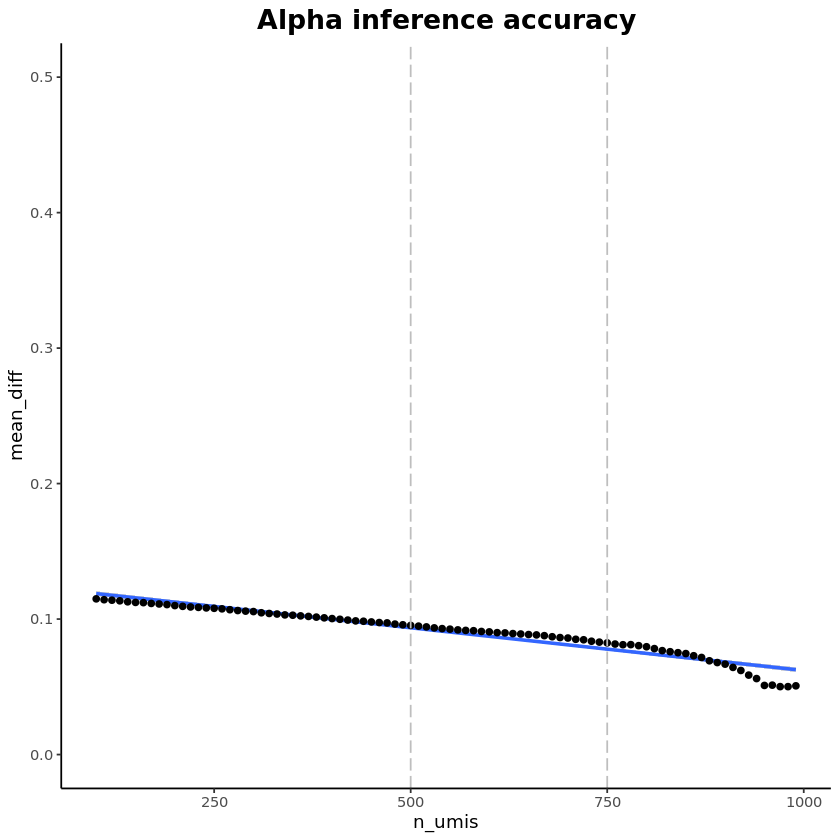

In [35]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), mean_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    df[as.character(x),'mean_diff'] = mean(abs(sim_info[rel_cells, 'alpha.1'] - alpha_tag[rel_cells]))
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=mean_diff)) +
    geom_smooth(method='lm', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,0.5)) +
    labs(title = 'Alpha inference accuracy') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp3/alpha_inference_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


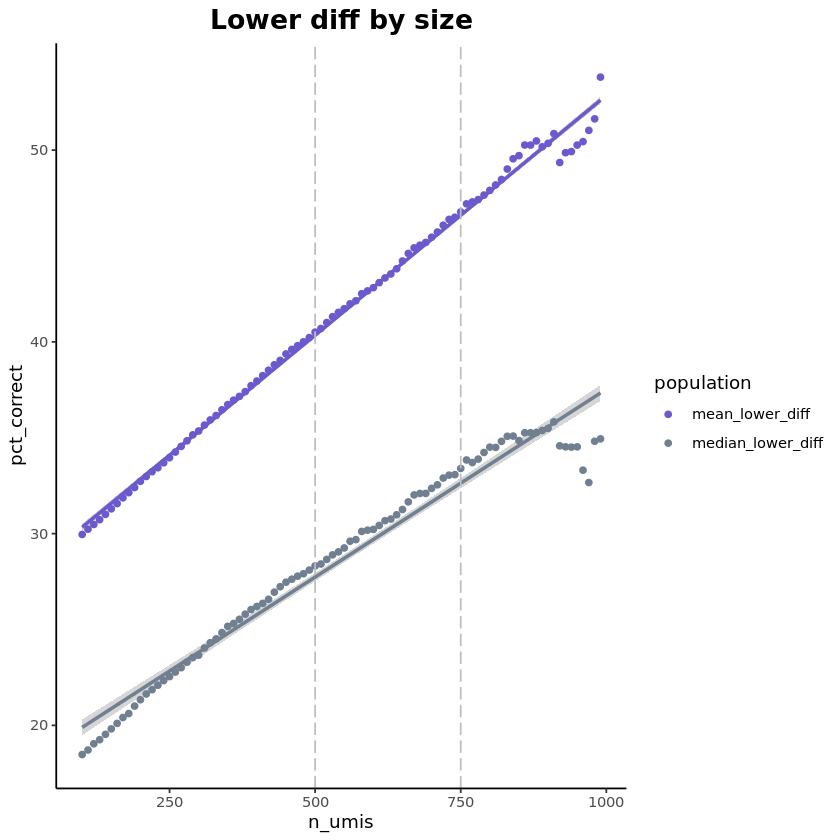

In [36]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), mean_lower_diff=NA, median_lower_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'mean_lower_diff'] = mean(sim_mle_res[rel_cells, 'lower_diff'])
        df[as.character(x),'median_lower_diff'] = median(sim_mle_res[rel_cells, 'lower_diff'])
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('slateblue', 'slategray')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    #scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Lower diff by size') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp3/lowerdiff_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


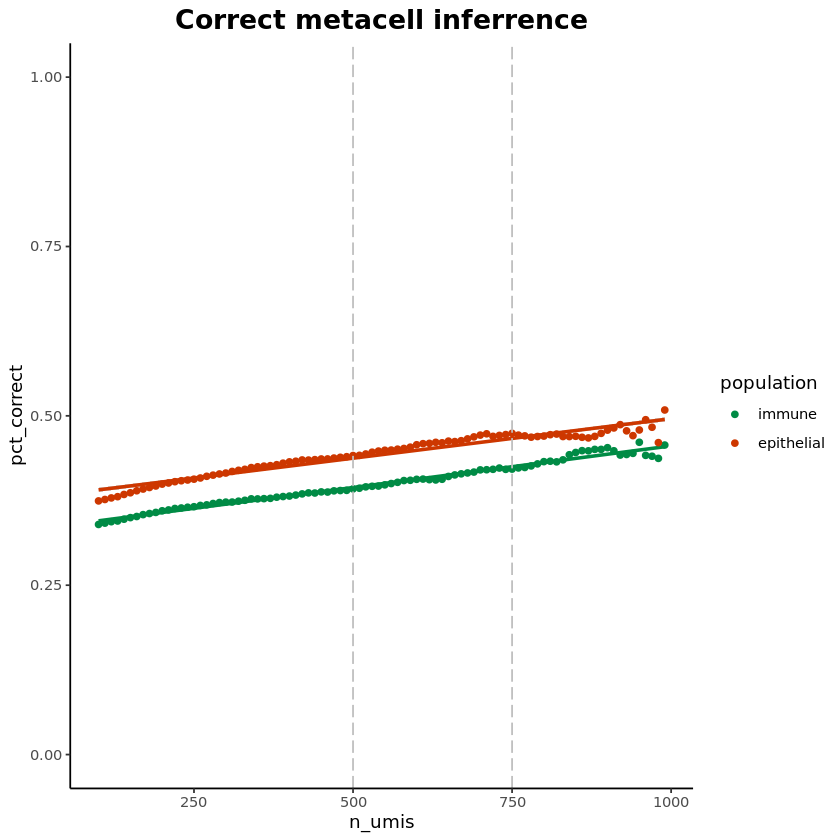

In [37]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.1']] == sim_mle_res[rel_cells, 'a_mc']) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.2']] == sim_mle_res[rel_cells, 'b_mc']) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Correct metacell inferrence') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp3/mc_inference_bysize.png", dpi=1200)

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


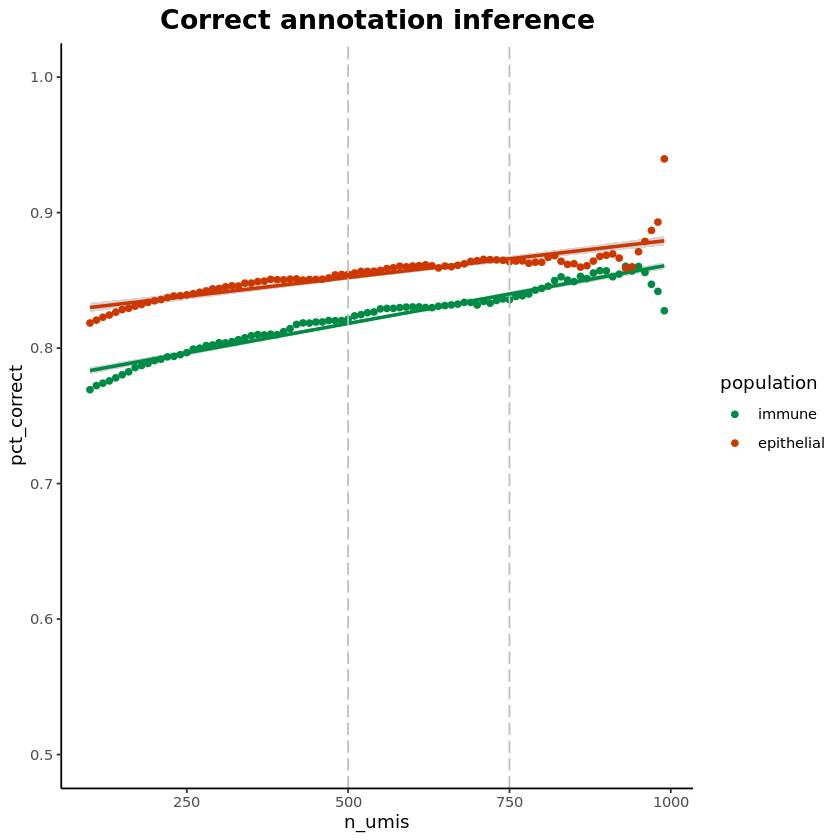

In [38]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 10), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 10)){
    rel_cells = names(sim_sizes)[sim_sizes >= x]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.1']]] == sin_cl@annots[sim_mle_res[rel_cells, 'a_mc']]) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.2']]] == sin_cl@annots[sim_mle_res[rel_cells, 'b_mc']]) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='lm', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0.5,1)) +
    labs(title = 'Correct annotation inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp3/annot_inference_bysize.png", dpi=1200)

In [39]:
pic_sizes = colSums(db_mat@mat)

In [40]:
pic_sizes = pic_sizes[pic_sizes >= 100]

Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


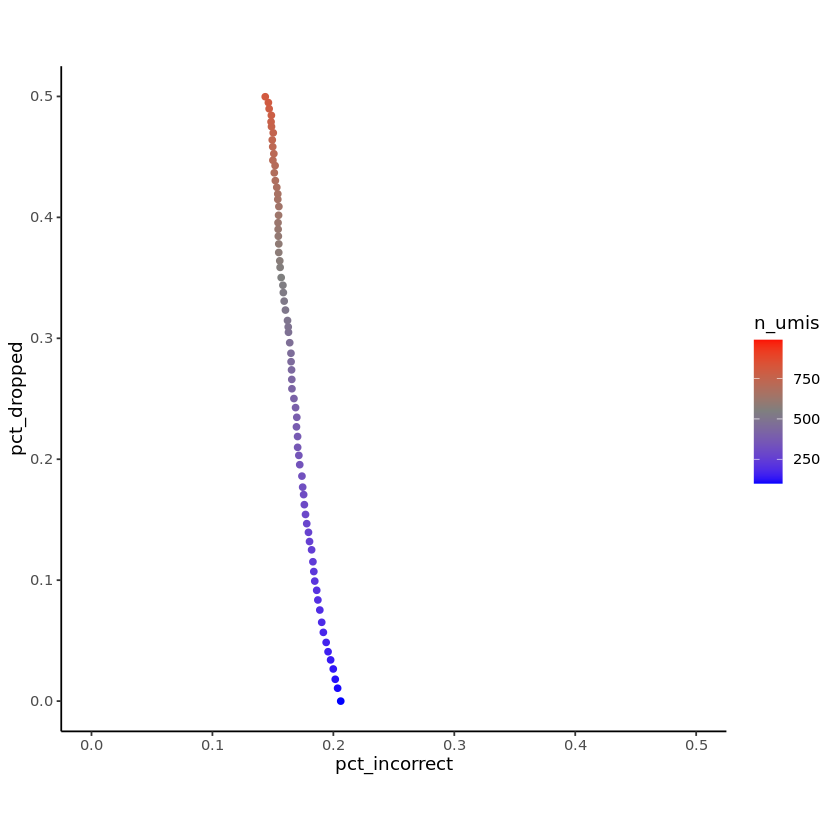

In [41]:
df %>% 
    mutate(pct_incorrect = 1-rowMeans(.)) %>%
    mutate(pct_dropped=sapply(as.numeric(rownames(.)), function(x){sum(pic_sizes < x) / length(pic_sizes)})) %>%
    rownames_to_column('n_umis') %>% 
    mutate(n_umis=as.numeric(n_umis)) %>%
ggplot(aes(y=pct_dropped, x=pct_incorrect, color=n_umis)) +
    #geom_smooth(method = 'lm', color='black', se=F) +
    geom_point() +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 550) +
    scale_x_continuous(limits = c(0, 0.5)) +
    scale_y_continuous(limits = c(0, 0.5)) +
    coord_fixed()

# Simulated PICs - for QC

In [42]:
k = 10000
numis = rep(500, k)

res = simulate_doublets(mat_id = "kinetics_singlets", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = numis)

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


,sim.1,sim.2,alpha.1,alpha.2
,<chr>,<chr>,<dbl>,<dbl>
Sim1,AB408_P24,AB241_G8,0.592,0.408
Sim2,AB541_D24,AB249_K17,0.144,0.856
Sim3,AB415_C17,AB152_J21,0.338,0.662
Sim4,AB322_H6,AB158_I21,0.488,0.512
Sim5,AB335_G6,AB168_L8,0.782,0.218
Sim6,AB527_C6,AB129_J12,0.660,0.340


In [43]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "kinetics_mc", 
                                      mat_id = "kinetics_singlets", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [44]:
sim_mle_res$alpha = sim_alpha

In [45]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [46]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [47]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [48]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [49]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_sim_info_final.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_sim_mle_res_final.txt")

In [50]:
#Rerun
sim_info = read.delim("annotations/cd45_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/cd45_sim_mle_res_final.txt", row.names = 1)

In [51]:
epithelial_confu = table(sin_cl@mc[ as.vector( sim_info$sim.1)], sim_mle_res$a_mc)
epithelial_n = epithelial_confu / rowSums(epithelial_confu)
immune_confu = table(sin_cl@mc[ as.vector( sim_info$sim.2)], sim_mle_res$b_mc)
immune_n = immune_confu / rowSums(immune_confu)

zlim: 0<>1



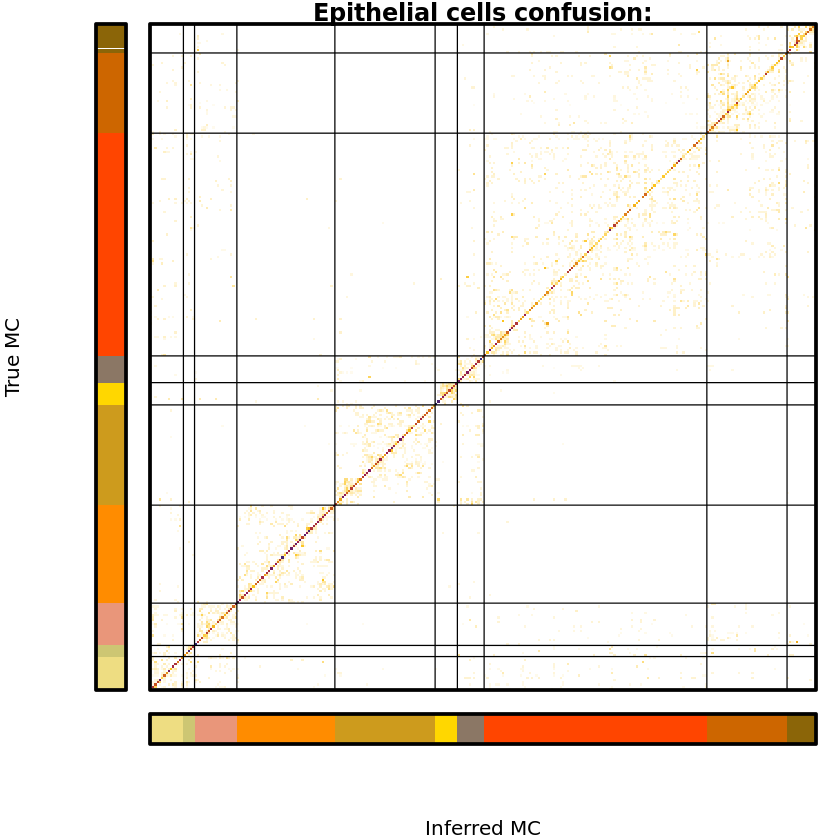

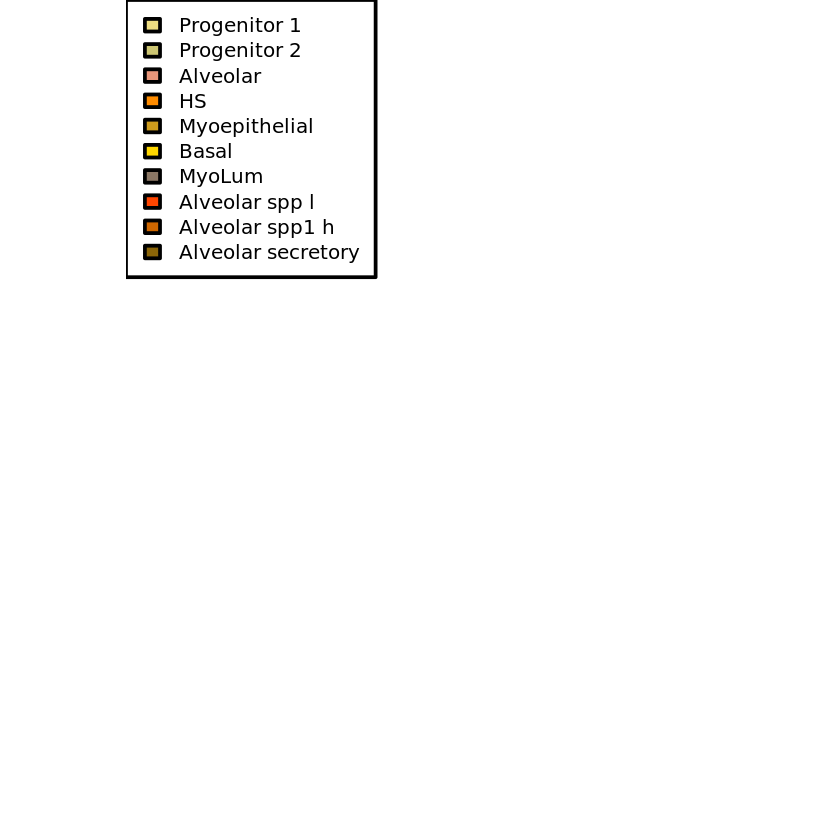

In [52]:
grad = colorRampPalette(c("white", "#FDC51D", "#CA531C", "#951851", "#36277A", "black"))(1000)
epithelial_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(epithelial_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
title("Epithelial cells confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=epithelial_pops,
       fill=group.colors[epithelial_pops],
       xpd = TRUE
       )

In [53]:
png("final_figs/supp3/epithelial_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
#title("Epithelial cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

zlim: 0<>1



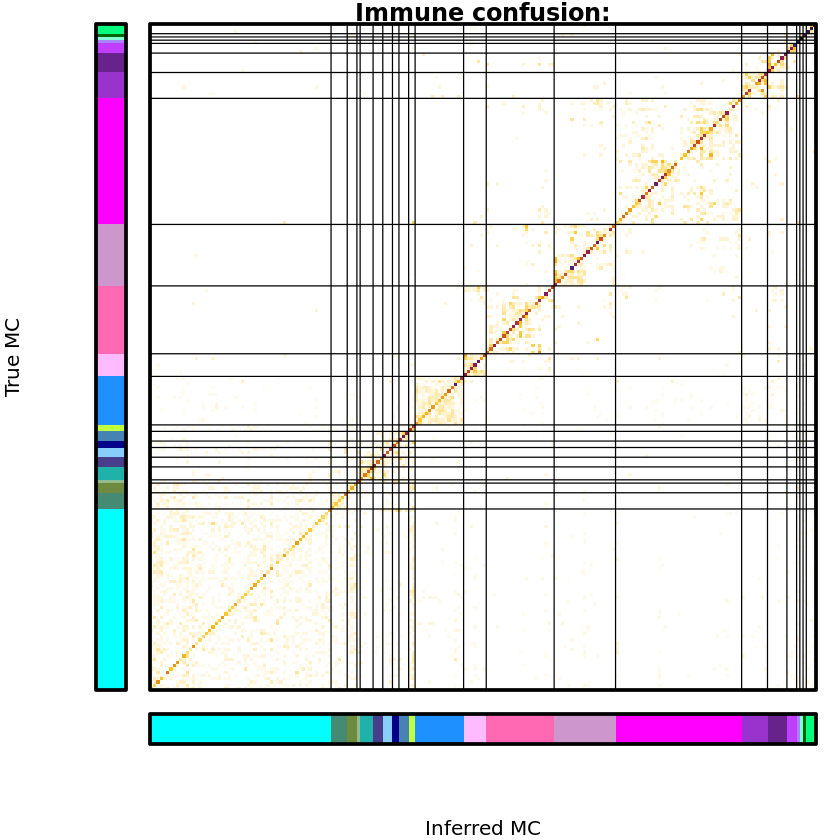

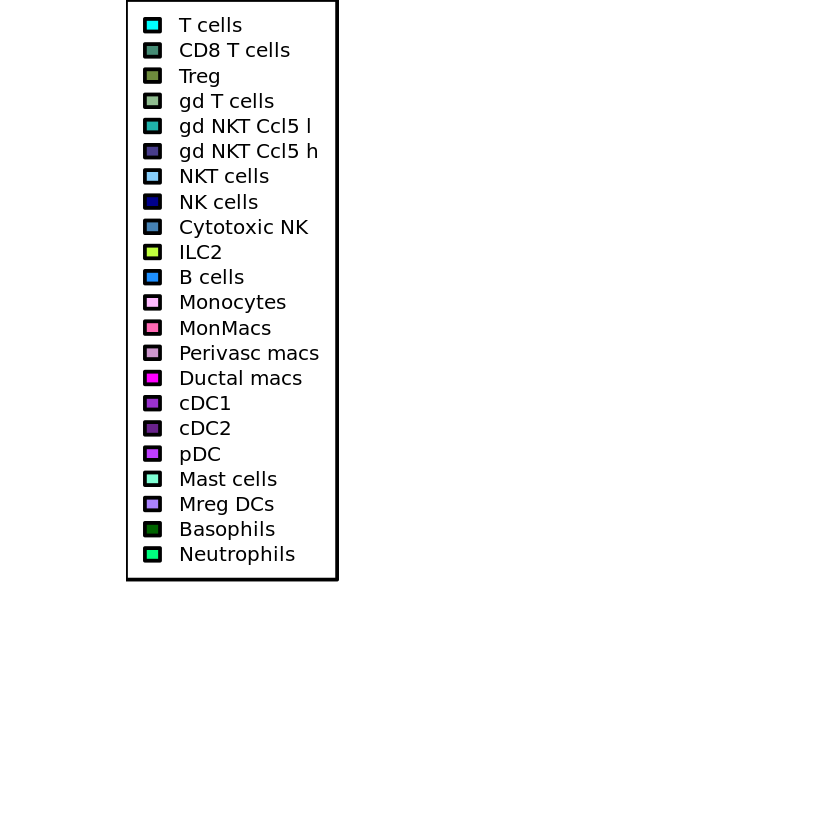

In [54]:
immune_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(immune_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls,vct = immune_cls); box()
title("Immune confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=immune_pops,
       fill=group.colors[immune_pops],
       xpd = TRUE
       )

In [55]:
png("final_figs/supp3/immune_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls, vct = immune_cls); box()
#title("immune cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

In [56]:
alpha_fit = estimate_mixing(sim_umis = sim_umis, 
                            alpha = sim_info$alpha.1, 
                            genes = lr_features, 
                            fname = "./temp.png",
                            500,
                            normalize = T)
alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]

In [57]:
png("final_figs/supp3/alpha_inference.png", width = 1000, height = 1000)
i = which(alpha_fit$lambda == alpha_fit$lambda.min)
plot(sim_info[, "alpha.1"], alpha_tag, pch = 20, col = rgb(0,0,0,0.6), xlim = c(0,1), ylim = c(0,1),
	cex=2, cex.main=2, main = paste0("R2=", round(1 - alpha_fit$cvm[i] / var(sim_info$alpha.1),4)), axes=F, xlab = "True alpha", ylab = "Inferred alpha")
abline(coef = c(0,1)); axis(1); axis(2,las=2)
dev.off()

png 
  2

# Real PIC-seq analysis

In [58]:
numis=500
pic_umis = read_large_umis("epcam_cd45_pics", cells = alive_pics)
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.8 GiB”
Retained 6173 PIC with >500 UMI



In [59]:
mle_res = run_pic_seq(mc_id = "kinetics_mc", 
                      mat_id = "kinetics_singlets", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(mle_res)

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB542_C20,364,699,-160.1870,0.3473064
AB542_E19,205,680,-127.5891,0.8472657
AB542_H22,408,698,-140.1500,0.2984980
AB542_K12,252,660,-148.7182,0.8420778
AB542_M8,196,645,-121.8649,0.4557147
AB542_M1,226,700,-147.1004,0.2177039


In [60]:
mle_res$sin_alpha = with(mle_res, round(alpha))
mle_res$sin_ll = with(mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
mle_res$diff = with(mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [61]:
mle_res$imm_alpha = with(mle_res, 0)
mle_res$imm_ll = with(mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
mle_res$imm_diff = with(mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [62]:
mle_res$epi_alpha = with(mle_res, 1)
mle_res$epi_ll = with(mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
mle_res$epi_diff = with(mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [63]:
write.table(mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_mle_res.txt")

### Epithelial singlets - PIC-seq

In [64]:
numis=500
pic_umis = read_large_umis("kinetics_singlets", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% epithelial_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

epi_mle_res = run_pic_seq(mc_id = "kinetics_mc", 
                      mat_id = "kinetics_singlets", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(epi_mle_res)

epi_mle_res$sin_alpha = with(epi_mle_res, round(alpha))
epi_mle_res$sin_ll = with(epi_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$diff = with(epi_mle_res, ll - sin_ll)

epi_mle_res$epi_alpha = 1
epi_mle_res$epi_ll = with(epi_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$epi_diff = with(epi_mle_res, ll - epi_ll)

epi_mle_res$imm_alpha = 0
epi_mle_res$imm_ll = with(epi_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$imm_diff = with(epi_mle_res, ll - imm_ll)

write.table(epi_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_epi_mle_res.txt")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Retained 10627 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB529_N3,300,713,-119.43444,0.7980697
AB541_G24,315,584,-98.16971,0.9273993
AB541_I20,279,698,-120.78192,0.9085418
AB541_P4,240,699,-78.32024,0.8864814
AB541_H8,283,689,-101.20143,0.7691590
AB541_K3,274,515,-120.83211,0.9112659


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(ob

### Immune singlets - PIC-seq

In [25]:
numis=500
pic_umis = read_large_umis("kinetics_singlets", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% immune_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

imm_mle_res = run_pic_seq(mc_id = "kinetics_mc", 
                      mat_id = "kinetics_singlets", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.png", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(imm_mle_res)

imm_mle_res$sin_alpha = with(imm_mle_res, round(alpha))
imm_mle_res$sin_ll = with(imm_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$diff = with(imm_mle_res, ll - sin_ll)

imm_mle_res$epi_alpha = 1
imm_mle_res$epi_ll = with(imm_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$epi_diff = with(imm_mle_res, ll - epi_ll)

imm_mle_res$imm_alpha = 0
imm_mle_res$imm_ll = with(imm_mle_res, pic_ll_to_pair('kinetics_mc', 'kinetics_singlets', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$imm_diff = with(imm_mle_res, ll - imm_ll)

write.table(imm_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/cd45_imm_mle_res.txt")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Retained 11289 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.

,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB529_B12,355,701,-177.8167,0.02564836
AB529_A9,188,680,-188.8801,0.07678858
AB529_A13,319,669,-173.2498,0.02822223
AB529_H16,372,671,-165.4381,0.01280374
AB529_M14,355,695,-183.0424,0.29620433
AB529_H14,282,692,-170.1994,0.06012212


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(ob

# Post PIC-seq

In [39]:
#rerun
mle_res = read.delim("annotations/cd45_mle_res.txt", stringsAsFactors = F, row.names=1)
epi_mle_res = read.delim("annotations/cd45_epi_mle_res.txt", stringsAsFactors = F, row.names=1)
imm_mle_res = read.delim("annotations/cd45_imm_mle_res.txt", stringsAsFactors = F, row.names=1)
head(mle_res)

,a_mc,b_mc,ll,alpha,sin_alpha,sin_ll,diff,imm_alpha,imm_ll,imm_diff,epi_alpha,epi_ll,epi_diff
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
AB542_C20,364,699,-160.1870,0.3473064,0,-147.8228,-12.364241,0,-147.8228,-12.364241,1,-321.6442,161.45721
AB542_E19,205,680,-127.5891,0.8472657,1,-138.3356,10.746529,0,-394.7233,267.134220,1,-138.3356,10.74653
AB542_H22,408,698,-140.1500,0.2984980,0,-136.5455,-3.604544,0,-136.5455,-3.604544,1,-320.0251,179.87505
AB542_K12,252,660,-148.7182,0.8420778,1,-192.5788,43.860569,0,-582.5677,433.849461,1,-192.5788,43.86057
AB542_M8,196,645,-121.8649,0.4557147,0,-119.6257,-2.239145,0,-119.6257,-2.239145,1,-348.0581,226.19320
AB542_M1,226,700,-147.1004,0.2177039,0,-138.6293,-8.471049,0,-138.6293,-8.471049,1,-478.6639,331.56352


In [40]:
mle_res$lower_diff = pmin(mle_res$imm_dif, mle_res$epi_diff)
epi_mle_res$lower_diff = pmin(epi_mle_res$imm_dif, epi_mle_res$epi_diff)
imm_mle_res$lower_diff = pmin(imm_mle_res$imm_dif, imm_mle_res$epi_diff)

In [41]:
nrow(mle_res)

[1] 6085

In [42]:
#Rerun
sim_info = read.delim("annotations/cd45_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/cd45_sim_mle_res_final.txt", row.names = 1)

In [43]:
min_thresh = ceiling(min(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [44]:
max_thresh = floor(max(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [45]:
thresh_df = data.frame(thresh=seq(min_thresh, max_thresh, 0.1),
                       singlet_pctg=sapply(seq(min_thresh, max_thresh, 0.1), function(thresh){
    mean(sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res), sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
                           }),
                       simpic_pctg=sapply(seq(min_thresh, max_thresh, 0.1), function(thresh){
        (sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
                           })
                      )

In [46]:
max_df = thresh_df[thresh_df$singlet_pctg - thresh_df$simpic_pctg == max(thresh_df$singlet_pctg - thresh_df$simpic_pctg),]
singlet_pctg = mean(max_df$singlet_pctg)

In [73]:
thresh = max_df$thresh

In [74]:
point_on_line = (max_df$singlet_pctg + max_df$simpic_pctg) / 2

In [87]:
#thresh = thresh_df[abs(thresh_df$singlet_pctg - 0.75) == min(abs(thresh_df$singlet_pctg - 0.75)),'thresh']

In [88]:
#point_on_line = (thresh_df[thresh_df$thresh == thresh,]$singlet_pctg + thresh_df[thresh_df$thresh == thresh,]$simpic_pctg) / 2

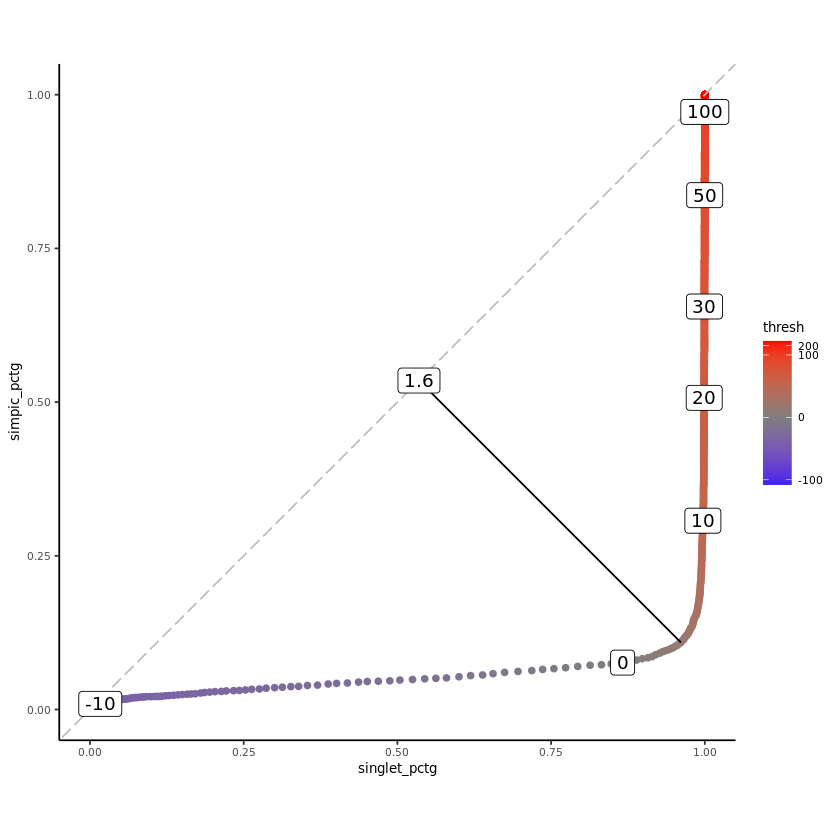

In [175]:
ggplot(thresh_df, aes(x=singlet_pctg, y=simpic_pctg, color=thresh)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, color='gray', linetype='longdash') +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 0, trans='pseudo_log') +
    geom_label(data=thresh_df[thresh_df$thresh %in% c(seq(-10,30,10), 50, 100),],#[round(thresh_df$thresh, digits = -1) == thresh_df$thresh ,], 
               aes(label=thresh), color='black') +
    scale_y_continuous(limits = c(0,1)) +
    geom_segment(data=data.frame(x=point_on_line, 
                                 y=point_on_line, 
                                 x2=thresh_df[thresh_df$thresh == thresh,]$singlet_pctg, 
                                 y2=thresh_df[thresh_df$thresh == thresh,]$simpic_pctg), 
                 aes(x=x, y=y, xend=x2, yend=y2), color='black') +
    geom_label(data=data.frame(x=point_on_line, y=point_on_line, label=round(thresh, 1)), 
               aes(x=x, y=y, label=label), color='black') +
    coord_fixed() +
    theme(text = element_text(size=8))
ggsave("final_figs/supp3/exclusion_curve.png", dpi=1200, height=5, width=5.8)

Saving 6.67 x 6.67 in image


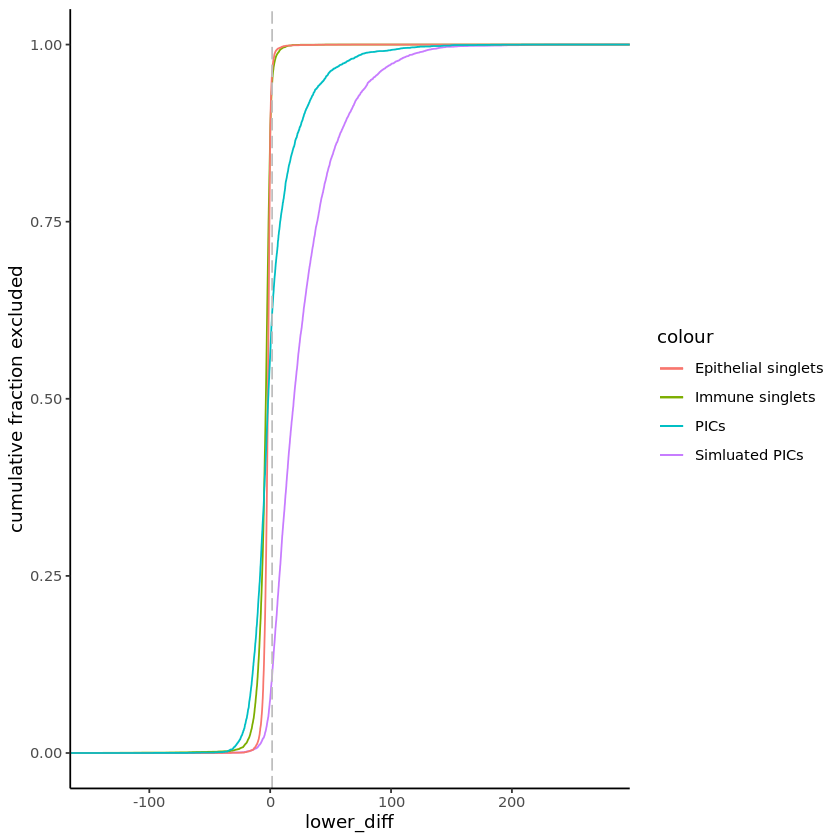

In [90]:
ggplot(sim_mle_res, aes(lower_diff)) + 
    stat_ecdf(geom = "step", aes(color='Simluated PICs')) +
    stat_ecdf(data = imm_mle_res, geom = "step", aes(color='Immune singlets')) +
    stat_ecdf(data = epi_mle_res, geom = "step", aes(color='Epithelial singlets')) +
    stat_ecdf(data = mle_res, geom = "step", aes(color='PICs')) +
    #scale_x_continuous(limits = c(-50, 200)) +
    geom_vline(xintercept = thresh, color='gray', linetype='longdash') +
    labs(y="cumulative fraction excluded")
ggsave("final_figs/supp3/exclusion_by_thresh.png", dpi=1200)

In [91]:
#thresh = round(max_df$thresh, 1)
message("Epithelial singlets - ", sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res))
message("Immune singlets - ", sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
message("Simulated PICs - ", sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
message("Experimental PICs - ", sum(mle_res$lower_diff < thresh) / nrow(mle_res))

Epithelial singlets - 0.961127596439169

Immune singlets - 0.944449793010494

Simulated PICs - 0.109

Experimental PICs - 0.619063270336894



In [92]:
diff_excluded = rownames(mle_res)[mle_res$lower_diff < thresh]

In [93]:
length(diff_excluded)

[1] 3767

In [94]:
size_excluded = rownames(mle_res)[db_mat@cell_metadata[rownames(mle_res),'total_counts'] < 500]

In [95]:
length(size_excluded)

[1] 0

In [96]:
to_exclude = union(diff_excluded, size_excluded)

In [97]:
length(to_exclude)

[1] 3767

In [98]:
good_pics = setdiff(rownames(mle_res), to_exclude)

In [99]:
writeLines(good_pics, 'annotations/cd45_good_pics_final.txt')

In [100]:
length(good_pics)

[1] 2318

In [101]:
sum(mle_res$lower_diff < thresh) / nrow(mle_res)

[1] 0.6190633

Saving 6.67 x 6.67 in image


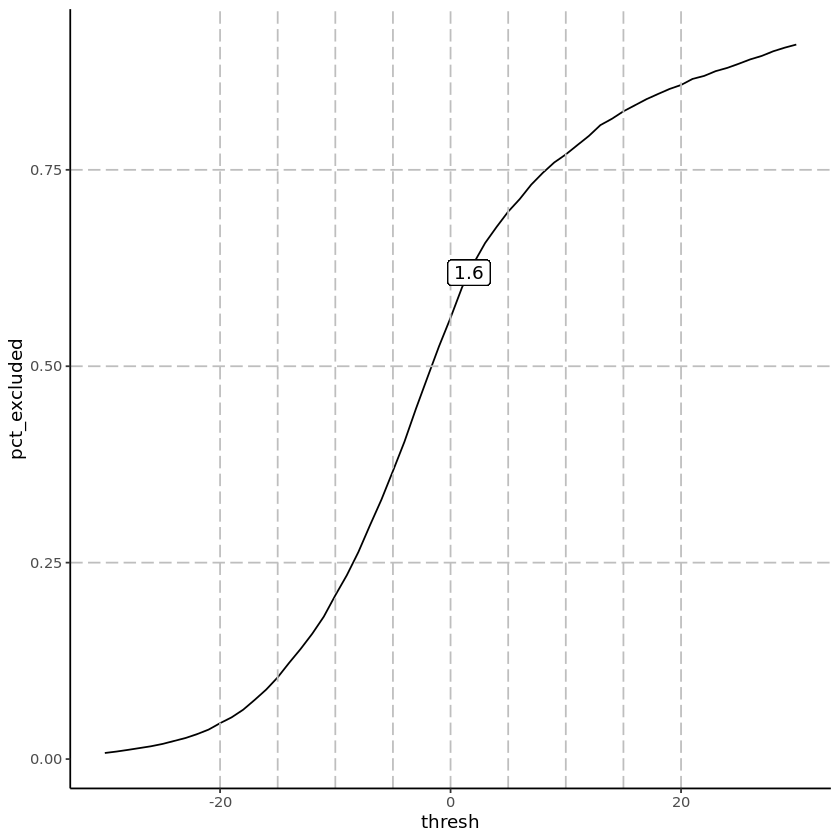

In [156]:
data.frame(thresh=-30:30, pct_excluded=sapply(-30:30, function(thresh){sum(mle_res$lower_diff < thresh) / nrow(mle_res)})) %>%
    ggplot(aes(x=thresh, y=pct_excluded)) +
    geom_line() +
    geom_vline(xintercept = c(seq(-20, 20, 5)), color='gray', linetype='longdash') +
    geom_hline(yintercept = c(0.25, 0.5, 0.75), color='gray', linetype='longdash') +
    geom_label(x=thresh, y=sum(mle_res$lower_diff < thresh) / nrow(mle_res), label=round(thresh,1))
ggsave("final_figs/supp3/real_exclusion_curve.png", dpi=1200)

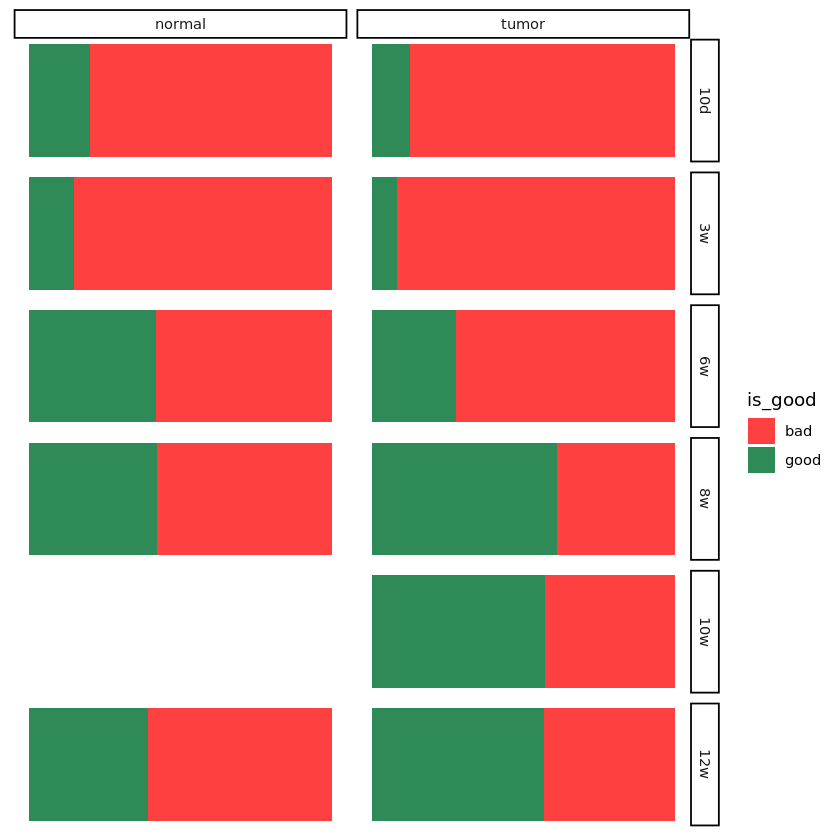

In [180]:
db_mat@cell_metadata[rownames(mle_res),] %>% mutate(is_good=ifelse(rownames(mle_res) %in% good_pics, 'good', 'bad'),
                                                    Age=factor(Age, levels=age_order)) %>%
    ggplot(aes(x=1, y=1, fill=is_good)) +
    geom_bar(stat='identity', position = 'fill', orientation = 'y') +
    facet_grid(Age ~ condition) +
    scale_fill_manual(values = c('brown1', 'seagreen')) +
    theme(axis.title = element_blank(), axis.text=element_blank(), axis.ticks = element_blank(), axis.line = element_blank())
ggsave("final_figs/supp3/exclusion_by_timepoint_condition.png", dpi=1200, height=3, width=3)

# Heatmaps for proof

In [104]:
db_umis = read_large_umis("epcam_cd45_pics", cells = rownames(mle_res))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


In [105]:
epithelial_umis = read_large_umis("kinetics_singlets", cells = epithelial_cells)
immune_umis = read_large_umis("kinetics_singlets", cells = immune_cells)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


In [106]:
epithelial_umis = epithelial_umis[,sample(ncol(epithelial_umis), size=ncol(db_umis))]

In [107]:
immune_umis = immune_umis[,sample(ncol(immune_umis), size=ncol(db_umis))]

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


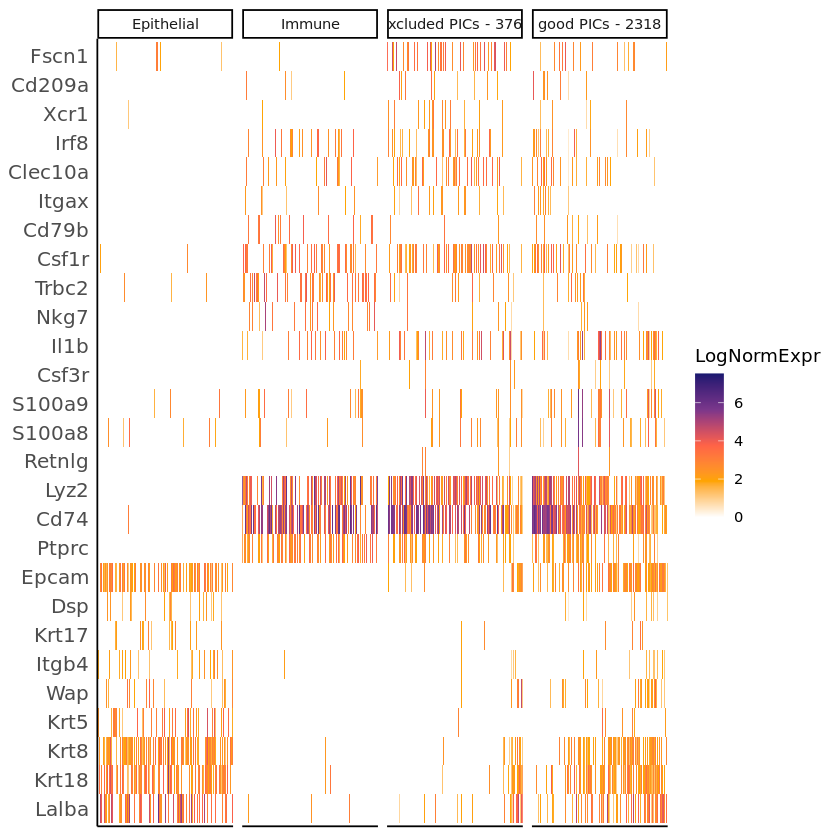

In [108]:
disp_genes = c('Lalba', 'Krt18', 'Krt8', 'Krt5', 'Wap', 'Itgb4', 'Krt17', 'Dsp', 'Epcam', 
               'Ptprc', 'Cd74', 'Lyz2', 'Retnlg', 'S100a8', 'S100a9', 'Csf3r', 'Il1b',
               'Nkg7', 'Trbc2', 'Csf1r', 'Cd79b', 'Itgax', 'Clec10a', 'Irf8', 'Xcr1', 'Cd209a', 'Fscn1')

db_umis = read_large_umis("epcam_cd45_pics", cells = rownames(mle_res))
focus_mat = t(db_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))

df1 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% 
    cbind(source=rep(ifelse(pmin(mle_res$epi_diff, mle_res$imm_diff) < thresh, 
                            paste0('excluded PICs - ', length(diff_excluded)), 
                            paste0('good PICs - ', length(good_pics))), 
                     each=length(disp_genes)))
focus_mat = t(epithelial_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df2 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Epithelial')

focus_mat = t(immune_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df3 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Immune')

df1$cell_name = factor(df1$cell_name, 
                       levels=rownames(mle_res)[order(mle_res$alpha)])

ggplot(rbind(df1, df2, df3) %>% mutate(source=factor(source, levels=c('Epithelial', 'Immune', 
                                                                      paste0('excluded PICs - ', length(diff_excluded)),
                                                                      paste0('good PICs - ', length(good_pics))))), 
       aes(x=cell_name, y=gene, fill=LogNormExpr)) +
    geom_tile() +
    scale_fill_gradientn(colors=c("white", "orange", "tomato", "mediumorchid4", "midnightblue")) +
    facet_grid(~ source, scales = 'free_x') +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks = element_blank(),
          axis.title.y = element_blank(), axis.text = element_text(size = 12))

ggsave("final_figs/supp3/gene_compare_all.png", dpi=1200, width=15, height=5)

In [182]:
write_lines(rev(disp_genes), "final_figs/supp3/short_hm_gene_list.txt")

In [110]:
#rerun
alpha = mle_res[good_pics, "alpha"]; names(alpha) = good_pics
epithelial_mc = mle_res[good_pics, "a_mc"]; names(epithelial_mc) = good_pics
immune_mc = mle_res[good_pics, "b_mc"]; names(immune_mc) = good_pics
parser_epithelial = color2name[ sin_cl@colors[ epithelial_mc]]; names(parser_epithelial) = good_pics
parser_immune = color2name[ sin_cl@colors[ immune_mc]]; names(parser_immune) = good_pics

table(parser_epithelial)
table(parser_immune)

parser_epithelial
          Alveolar Alveolar secretory     Alveolar spp l    Alveolar spp1 h 
                96                243                811                322 
             Basal                 HS      Myoepithelial             MyoLum 
                58                379                125                 71 
      Progenitor 1       Progenitor 2 
               135                 78 

parser_immune
      B cells     Basophils   CD8 T cells          cDC1          cDC2 
          181             5            19           161           142 
 Cytotoxic NK   Ductal macs gd NKT Ccl5 h gd NKT Ccl5 l    gd T cells 
           17           353            16            17             3 
         ILC2       MonMacs     Monocytes      Mreg DCs   Neutrophils 
           21           332           118           192           183 
     NK cells     NKT cells           pDC Perivasc macs       T cells 
            7            20            26           177           309 
         Treg 
           19 

In [111]:
cell_stats = rbind(db_mat@cell_metadata, sin_mat@cell_metadata[colnames(db_mat@cell_metadata)])
comb = with(cell_stats, paste0(ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet"), "@",
                               condition)); 
names(comb) = rownames(cell_stats)
table(comb)

comb
    PIC@normal      PIC@tumor Singlet@normal  Singlet@tumor 
          4224           6785          18432          22711 

In [112]:
#cell_stats = sc_mat@cell_metadata[ union(db_mat@cells, sin_mat@cells),]
comb = with(cell_stats, paste0(ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet"), "@",
                               condition, "@", Cell_type)); 
names(comb) = rownames(cell_stats)
table(comb)

comb
PIC@normal@EPCAM-CD45  PIC@tumor@EPCAM-CD45  Singlet@normal@CD45- 
                 4224                  6785                  6758 
 Singlet@normal@CD45+  Singlet@normal@EPCAM   Singlet@tumor@CD45- 
                 7334                  4340                  6987 
  Singlet@tumor@CD45+   Singlet@tumor@EPCAM 
                10676                  5048 

In [113]:
#cell_stats = sc_mat@cell_metadata[ union(db_mat@cells, sin_mat@cells),]
comb = with(cell_stats, paste0(ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet"), "@",
                               condition, "@", Age, "@", Cell_type)); 
names(comb) = rownames(cell_stats)
table(comb)

comb
PIC@normal@10d@EPCAM-CD45 PIC@normal@12w@EPCAM-CD45  PIC@normal@3w@EPCAM-CD45 
                      768                      1152                      1152 
 PIC@normal@6w@EPCAM-CD45  PIC@normal@8w@EPCAM-CD45  PIC@tumor@10d@EPCAM-CD45 
                      384                       768                       768 
 PIC@tumor@10w@EPCAM-CD45  PIC@tumor@12w@EPCAM-CD45   PIC@tumor@3w@EPCAM-CD45 
                     1536                      1920                      1409 
  PIC@tumor@6w@EPCAM-CD45   PIC@tumor@8w@EPCAM-CD45  Singlet@normal@10d@CD45- 
                      384                       768                       905 
 Singlet@normal@10d@CD45+  Singlet@normal@10d@EPCAM  Singlet@normal@10w@CD45- 
                     1134                       909                      1293 
 Singlet@normal@10w@CD45+  Singlet@normal@10w@EPCAM  Singlet@normal@12w@CD45- 
                     1377                       330                       610 
 Singlet@normal@12w@CD45+  Singlet@normal@12w@E

In [114]:
cell_stats$is_pic = ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet")

In [115]:
cell_stats$epithelial_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                    parser_epithelial[rownames(cell_stats)], 
                                    ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% epithelial_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [116]:
cell_stats$immune_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                parser_immune[rownames(cell_stats)], 
                                ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% immune_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [117]:
imhm_genes = c(rev(c('Cd79b', 'Ms4a1', 'Cd19', 'H2-DMb2',
                     'S100a4', 'Il7r', 'Cxcr6', 
                     'Il1rl1', 'Csf2', 'Rora',
                     'Gzma', 'Prf1', 'Ncr1', 
                     'Klrd1', 'Ccl5', 'Nkg7', 'Gzmb', 
                     'Itgae', 'Trgc1', 'Trgc2', 'Trdc',
                     'Icos', 'Ctla4', 'Foxp3', 'Cd4',
                     'Cd8a', 'Cd8b1', 
                     'Trbc2', 'Trbc1', 'Trac', 'Cd3e', 'Tcf7')),
               rev(c('Csf3r', 'S100a8', 'S100a9', 'Retnlg',
                     'Il6', 'Mcpt8', 'Osm', 'Ccl3',
                     'Cma1', 'Cpa3', 'Tpsb2', 'Mcpt4',
                     'Fscn1', 'Epsti1', 'Ccl22', 'Ccl17',
                     'Siglech', 'Cd209d', 'Ccr9', 
                     'Clec10a', 'H2-Aa', 'H2-Ab1', 'Cd74',
                     'Cd209a', 'Irf8', 'Xcr1',
                     'Cx3cr1', 'Trem2', 'Ms4a7',
                     'C1qa', 'Il1b',
                     'Csf1r', 'Cd163', 'Cd209f', 
                     'Lyve1', 'Mrc1', 'F13a1',
                     'Retnla', 'Ccr2', 'Ccl6', 'Lyz1',
                     'Lyz2', 'Ear2', 'Plac8')))
epi_hm_genes = c("Kit", "Cd14", "Aldh1a3", "Mfge8", "Fcgbp", "Wfdc18", "Krt8", "Krt18", "Cp", 
                 "Lalba", "Csn3", 
                 "Cited1", "Pgr", "Esr1", "Prlr", 
                 "Myl9", "Acta2", #"Pdpn", "Mylk", "Myh11", "Ecrg4", "Oxtr", "Tpm2", 
                 "Krt5", "Krt14", 
                 "Krt17", "Rbp1", "Rflnb", "Gja1", #"Pclaf", "Tuba1b", "Hmgb2", "Ccna2",
                 #"Spp1",
                 "Wap", "Csn1s1", "Csn1s2a", "Csn2", "Thrsp", "Car6", "Saa1", "Saa2")
disp_genes = c(imhm_genes, epi_hm_genes)

In [118]:
hm_stats = cell_stats %>% 
    filter(!is.na(epithelial_type) | !is.na(immune_type)) %>% 
    select(Age, condition, is_pic, epithelial_type, immune_type)

In [119]:
pic_rows = which(hm_stats$is_pic == 'PIC')

In [120]:
epithelial_rows = which(is.na(hm_stats$immune_type))

In [121]:
immune_rows = which(is.na(hm_stats$epithelial_type))

In [122]:
hm_df = hm_stats[c(pic_rows, sample(epithelial_rows, length(pic_rows)), sample(immune_rows, length(pic_rows))),]

In [123]:
hm_df$alpha = ifelse(hm_df$is_pic == 'PIC', alpha[rownames(hm_df)], 
                     ifelse(is.na(hm_df$immune_type), 1, 0))

In [124]:
hm_df = hm_df %>% mutate(Source = factor(ifelse(is_pic == "PIC", 'PIC', ifelse(is.na(epithelial_type), 'Immune', 'Epithelial')),
                                         levels=c('Immune', 'Epithelial', 'PIC')),
                         immune_type=factor(immune_type, levels=cell_order),
                         epithelial_type=factor(epithelial_type, levels=cell_order))

In [125]:
hmgene_df = rbind(apply(t(sin_mat@mat[,rownames(hm_df %>% filter(is_pic =='Singlet'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes),
                  apply(t(db_mat@mat[,rownames(hm_df %>% filter(is_pic =='PIC'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes)) %>%
    as.matrix %>% t

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(disp_genes)

  # Now:
  data %>% select(all_of(disp_genes))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [126]:
c_vec = sin_cl@colors[!duplicated(sin_cl@colors)]
names(c_vec) = sin_cl@annots[!duplicated(sin_cl@annots)]

In [127]:
ha1 = HeatmapAnnotation(show_legend = F,
                        Immune_annot=factor(hm_df$immune_type, levels = cell_order), 
                        Epithelial_annot=factor(hm_df$epithelial_type, levels = cell_order), 
                        col = list(Immune_annot=c_vec, Epithelial_annot=c_vec))

ha2 = HeatmapAnnotation(alpha=hm_df$alpha,
                        col = list(alpha=colorRamp2(c(0, 0.5, 1), c("limegreen", "gray40", "firebrick3"))))

In [128]:
png(file="final_figs/supp3/heatmap_comb.png", 
    width = 10,
    height    = 10,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

hm_plot = Heatmap(hmgene_df[,rownames(hm_df)], 
                  row_names_gp = gpar(fontsize=6), 
                  show_column_dend = F, 
                  column_order = rownames(hm_df %>% arrange(is_pic, immune_type, epithelial_type, alpha)), 
                  row_order = disp_genes,
                  column_split = hm_df$Source,
                  row_split = factor(ifelse(disp_genes %in% imhm_genes, "Immune genes", "Epithelial genes"), 
                                            levels=c("Immune genes", "Epithelial genes")),
                  heatmap_legend_param = list(labels_gp = gpar(fontsize = 6)),
                  cluster_rows = F, 
                  cluster_columns =  F, 
                  top_annotation = ha1, 
                  bottom_annotation = ha2, 
                  show_column_names = F,
                  col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(10000), 
                  use_raster = F)
plot(hm_plot)
dev.off()

png 
  2

In [129]:
write_lines(disp_genes, "final_figs/supp3/full_hm_gene_list.txt")

In [130]:
disp_genes = c('Csn3', 'Lalba', 'Krt18', 'Krt8', 'Epcam', 'Retnlg', 'S100a8', 'S100a9', 'Csf3r', 'Il1b')
db_umis = read_large_umis("epcam_cd45_pics", cells = names(which(parser_immune == 'Neutrophils')))
focus_mat = t(db_umis)
focus_mat_norm = log1p((10000 / (1 - alpha[names(which(parser_immune == 'Neutrophils'))])) * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))

In [131]:
df1 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='PICs')

In [132]:
epithelial_umis = read_large_umis("kinetics_singlets", cells = epithelial_cells)
immune_umis = read_large_umis("kinetics_singlets", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] == 'Neutrophils']))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [133]:
epithelial_umis = epithelial_umis[,sample(ncol(epithelial_umis), size=ncol(immune_umis))]

In [134]:
focus_mat = t(epithelial_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df2 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Epithelial')

In [135]:
focus_mat = t(immune_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df3 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Neutrophils')

In [136]:
ncol(db_umis)

[1] 183

In [137]:
df1$cell_name = factor(df1$cell_name, 
                       levels=rownames(mle_res)[order(mle_res$alpha)])

Saving 6.67 x 6.67 in image


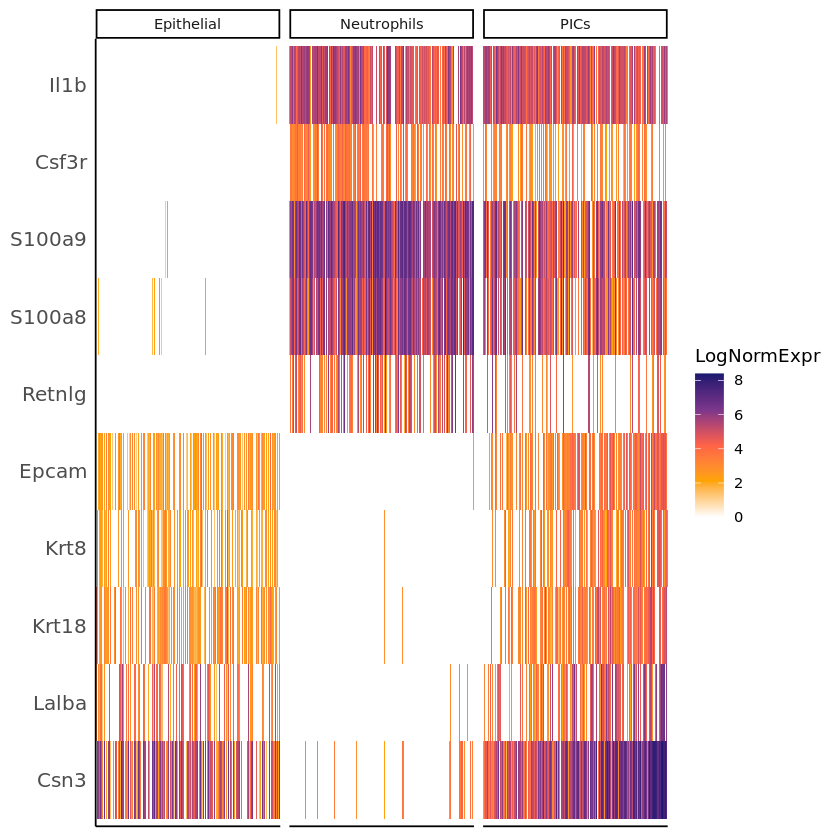

In [138]:
ggplot(rbind(df1, df2, df3), aes(x=cell_name, y=gene, fill=LogNormExpr)) +
    geom_tile() +
    scale_fill_gradientn(colors=c("white", "orange", "tomato", "mediumorchid4", "midnightblue")) +
    facet_grid(~ source, scales = 'free_x') +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks = element_blank(),
          axis.title.y = element_blank(), axis.text = element_text(size = 12))

ggsave("final_figs/fig3/neutrophil_gene_proof.png", dpi=1200)

In [139]:
write_lines(disp_genes, "final_figs/fig3/neutrophil_hm_gene_list.txt")

# Composition plots

In [140]:
immune_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('CD45+', 'EPCAM-CD45')) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, immune_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, immune_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=immune_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 30)

immune_replicate_df$annotation = factor(immune_replicate_df$annotation, levels=cell_order)
immune_replicate_df$condition = factor(immune_replicate_df$condition, levels=rev(cond_order))
immune_replicate_df$Age = factor(immune_replicate_df$Age, levels=age_order)
immune_replicate_df$is_pic = factor(immune_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#immune_replicate_df = remove_missing(immune_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'immune_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [141]:
epithelial_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('EPCAM', 'EPCAM-CD45')) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, epithelial_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, epithelial_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=epithelial_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 30)

epithelial_replicate_df$annotation = factor(epithelial_replicate_df$annotation, levels=cell_order)
epithelial_replicate_df$condition = factor(epithelial_replicate_df$condition, levels=rev(cond_order))
epithelial_replicate_df$Age = factor(epithelial_replicate_df$Age, levels=age_order)
epithelial_replicate_df$is_pic = factor(epithelial_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#epithelial_replicate_df = remove_missing(epithelial_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'epithelial_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [142]:
composition_plots = function(replicate_df, pop_name, exclude_ages=c('10w'), basedir='final_figs/fig3/composition'){
    means_df = replicate_df %>%
    group_by(Age, condition, is_pic, annotation) %>% 
    summarise(mean_fraction=mean(fraction)) %>%
    mutate_all(~replace(., is.na(.), 0)) %>%
    mutate(Age=factor(Age, levels=age_order), 
           condition=factor(condition, levels=cond_order), 
           is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        
    p = ggplot(means_df %>% filter(!Age %in% exclude_ages), aes(y=mean_fraction, x=is_pic, fill=annotation)) + 
    geom_bar(position="fill", stat="identity", orientation = "x") +
    scale_fill_manual(values = group.colors) +
    facet_grid(condition ~ Age) +
    theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.x = element_blank(),
          axis.text.x = element_text(vjust = 0.5, hjust = 1, angle = 90),
          legend.box.margin = margin(c(0,0,0,5)),
          legend.title = element_text(size=12),   
          strip.background = element_rect(linetype="blank"),
          axis.text.y = element_blank(), axis.title.y = element_blank(),
          axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
          axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0(basedir, "/composition_bar_", pop_name, ".png"), plot = p, width = 5, height = 6, dpi = 1200)
    ggsave(paste0(basedir, "/composition_bar_", pop_name, "_legend.png"), plot = l, width=4, height=6)
    
    for (annot in unique(means_df$annotation)){
        boxplot_df = replicate_df[replicate_df$annotation == annot,] %>% 
            mutate(condition=factor(condition, levels=rev(cond_order)), 
                   Age=factor(Age, levels=age_order), 
                   is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        plot_df = means_df[means_df$annotation == annot,] %>% 
            mutate(condition=factor(condition, levels=rev(cond_order)), 
                   Age=factor(Age, levels=age_order), 
                   is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        ggplot(plot_df, aes(x=Age, y=mean_fraction, col=is_pic)) +
            geom_line(aes(group=is_pic), size=1) +
            geom_boxplot(data=boxplot_df, 
                         aes(y=fraction), size=0.5, show.legend = F, width=0.2,
                         position = position_dodge(width = 0.25)) +
            scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
            facet_grid(~ condition) +
            labs(title=paste(annot, "fraction of cells")) +
            scale_x_discrete(limits=age_order) +
            expand_limits(y = 0) +
            theme(plot.title = element_text(hjust=0.5, size=20, face='bold'), strip.text = element_text(size=12))

        ggsave(paste0(basedir, "/fraction_final/fraction_", annot, "_box.png"), dpi = 1200)
    }
}

In [143]:
composition_plots(epithelial_replicate_df, 'epithelial')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 10d`, `condition = normal`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 

In [144]:
composition_plots(immune_replicate_df, 'immune')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 23 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 10d`, `condition = normal`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 22 remaining warnings.”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 

In [145]:
neutrophil_frac_df = immune_replicate_df[immune_replicate_df$annotation == 'Neutrophils' & 
                                         immune_replicate_df$Age %in% c('10w', '12w') & 
                                         immune_replicate_df$condition == 'tumor',] 

In [146]:
neutrophil_frac_df = neutrophil_frac_df %>% 
    dcast(is_pic ~ Age+Replicate) %>% 
    column_to_rownames('is_pic') %>% t %>% as.data.frame

Using fraction as value column: use value.var to override.



In [147]:
wilcox_res = wilcox.test(neutrophil_frac_df$Singlet, neutrophil_frac_df$PIC, paired = F)

In [148]:
wilcox_res


	Wilcoxon rank sum exact test

data:  neutrophil_frac_df$Singlet and neutrophil_frac_df$PIC
W = 0, p-value = 0.0003996
alternative hypothesis: true location shift is not equal to 0


Saving 6.67 x 6.67 in image


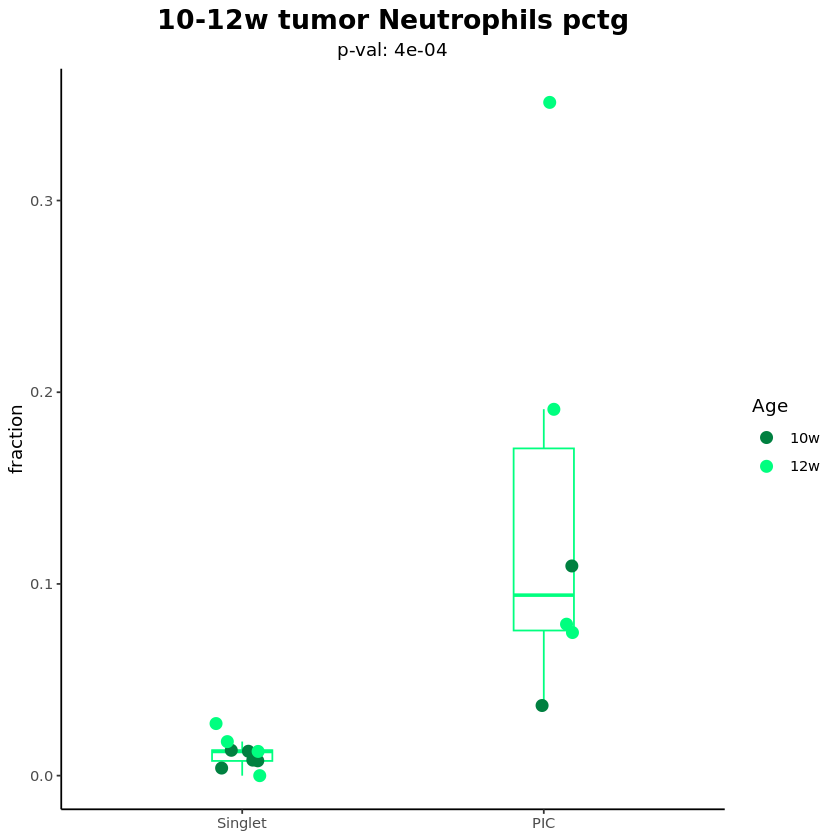

In [149]:
immune_replicate_df[immune_replicate_df$annotation == 'Neutrophils' & 
                    immune_replicate_df$Age %in% c('10w', '12w') & 
                    immune_replicate_df$condition == 'tumor',] %>%
    ggplot(aes(x=is_pic, y=fraction)) +
    geom_boxplot(color=group.colors['Neutrophils'], width=0.2, outlier.shape=NA) +
    geom_jitter(size=3, aes(color=Age), width = 0.1) +
    labs(title = '10-12w tumor Neutrophils pctg', subtitle = paste0("p-val: ", round(wilcox_res$p.value, 5))) +
    scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
    theme(axis.title.x=element_blank(), plot.title = element_text(hjust=0.5, size=16, face = 'bold'), 
          plot.subtitle = element_text(hjust=0.5))

ggsave('final_figs/fig3/composition/neutrophil_singlet_vs_pics_all.png', dpi=1200)

In [150]:
paired_wilcox_res = with(neutrophil_frac_df %>% filter(!is.na(PIC)), wilcox.test(Singlet, PIC, paired=T))

In [151]:
paired_wilcox_res


	Wilcoxon signed rank exact test

data:  Singlet and PIC
V = 0, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


Saving 6.67 x 6.67 in image


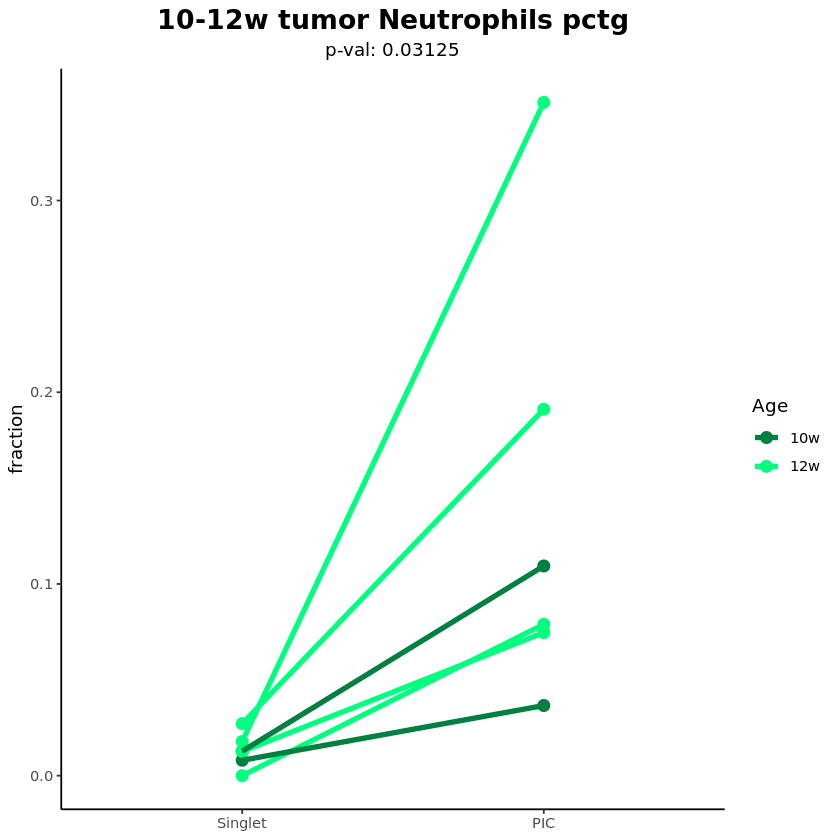

In [152]:
immune_replicate_df[immune_replicate_df$annotation == 'Neutrophils' & 
                    immune_replicate_df$Age %in% c('10w', '12w') & 
                    immune_replicate_df$condition == 'tumor',] %>%
    filter(Age == '12w' | Replicate %in% 4:5) %>%    
    ggplot(aes(x=is_pic, y=fraction, color=Age, group=interaction(Age,Replicate))) +
    geom_point(size=3) +
    geom_line(size=1.5) +
    labs(title = '10-12w tumor Neutrophils pctg', subtitle = paste0("p-val: ", round(paired_wilcox_res$p.value, 5))) +
    scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
    theme(axis.title.x=element_blank(), plot.title = element_text(hjust=0.5, size=16, face = 'bold'), 
          plot.subtitle = element_text(hjust=0.5))

ggsave('final_figs/fig3/composition/neutrophil_singlet_vs_pics.png', dpi=1200)

In [153]:
immune_replicate_df[immune_replicate_df$annotation == 'Neutrophils' & immune_replicate_df$Age %in% c('10w', '12w') & immune_replicate_df$condition == 'tumor',]

Age,condition,is_pic,Replicate,annotation,Count,total,fraction
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>
10w,tumor,PIC,4,Neutrophils,12,328,0.036585366
10w,tumor,PIC,5,Neutrophils,14,128,0.109375000
10w,tumor,Singlet,1,Neutrophils,2,507,0.003944773
10w,tumor,Singlet,2,Neutrophils,4,521,0.007677543
10w,tumor,Singlet,3,Neutrophils,8,603,0.013266998
10w,tumor,Singlet,4,Neutrophils,2,249,0.008032129
10w,tumor,Singlet,5,Neutrophils,3,235,0.012765957
12w,tumor,PIC,1,Neutrophils,59,168,0.351190476
12w,tumor,PIC,2,Neutrophils,69,361,0.191135734
